# Data Cleaning

## Data Dictionary

The raw data contains the following data per station per reading:

* Id - String - API Resource Id
* Name - String - The common name of the station
* PlaceType - String ?
* TerminalName - String - ?
* NbBikes - Integer - The number of available bikes
* NbDocks - Integer - The total number of docking spaces
* NbEmptyDocks - Integer - The number of available empty docking spaces
* Timestamp - DateTime - The moment this reading was captured
* InstallDate - DateTime - Date when the station was installed
* RemovalDate - DateTime - Date when the station was removed
* Installed - Boolean - If the station is installed or not
* Locked - Boolean - ?
* Temporary - Boolean - If the station is temporary or not (TfL adds temporary stations to cope with demand.)
* Latitude - Float - Latitude Coordinate
* Longitude - Float - Longitude Coordinate

The following variables will be derived from the raw data.

* NbUnusableDocks - Integer - The number of non-working docking spaces. Computed with NbUnusableDocks = NbDocks - (NbBikes + NbEmptyDocks)

## Set up

### Imports

In [3]:
%matplotlib inline

import logging
import itertools
import json
import os
import pickle
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from datetime import datetime
from os import listdir
from os.path import isfile, join
from src.data.parse_dataset import parse_dir, parse_json_files, get_file_list
from IPython.display import Image
from datetime import date

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Parse Raw Data 

### Define the Parsing Functions

In [65]:
def parse_cycles(json_obj):
    """Parses TfL's BikePoint JSON response"""

    return [parse_station(element) for element in json_obj]

def parse_station(element):
    """Parses a JSON bicycle station object to a dictionary"""

    obj = {
        'Id': element['id'],
        'Name': element['commonName'],
        'Latitude': element['lat'],
        'Longitude': element['lon'],
        'PlaceType': element['placeType'],
    }

    for p in element['additionalProperties']:
        obj[p['key']] = p['value']

        if 'timestamp' not in obj:
            obj['Timestamp'] = p['modified']
        elif obj['Timestamp'] != p['modified']:
            raise ValueError('The properties\' timestamps for station %s do not match: %s != %s' % (
            obj['id'], obj['Timestamp'], p['modified']))

    return obj

In [1]:
def bike_file_date_fn(file_name):
    """Gets the file's date"""

    return datetime.strptime(os.path.basename(file_name), 'BIKE-%Y-%m-%d:%H:%M:%S.json')

def create_between_dates_filter(file_date_fn, date_start, date_end):
    def filter_fn(file_name):
        file_date = file_date_fn(file_name)
        return file_date >= date_start and file_date <= date_end
    
    return filter_fn

### Quick Data View

#### Load Single Day Data

In [67]:
filter_fn = create_between_dates_filter(bike_file_date_fn, 
                                       datetime(2016, 5, 16, 7, 0, 0),
                                       datetime(2016, 5, 16, 23, 59, 59))

records = parse_dir('/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw', 
                    parse_cycles, sort_fn=bike_file_date_fn, filter_fn=filter_fn)

# records is a list of lists of dicts
df = pd.DataFrame(list(itertools.chain.from_iterable(records))) 

####  All Station View

In [68]:
df.head()

,Id,InstallDate,Installed,Latitude,Locked,Longitude,Name,NbBikes,NbDocks,NbEmptyDocks,PlaceType,RemovalDate,Temporary,TerminalName,Timestamp
0,BikePoints_1,1278947280000,true,51.529163,false,-0.109970,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
1,BikePoints_2,1278585780000,true,51.499606,false,-0.197574,"Phillimore Gardens, Kensington",12,37,25,BikePoint,,false,001018,2016-05-16T06:26:24.037
2,BikePoints_3,1278240360000,true,51.521283,false,-0.084605,"Christopher Street, Liverpool Street",6,32,26,BikePoint,,false,001012,2016-05-16T06:51:27.5
3,BikePoints_4,1278241080000,true,51.530059,false,-0.120973,"St. Chad's Street, King's Cross",14,23,9,BikePoint,,false,001013,2016-05-16T06:51:27.5
4,BikePoints_5,1278241440000,true,51.493130,false,-0.156876,"Sedding Street, Sloane Square",27,27,0,BikePoint,,false,003420,2016-05-16T06:46:27.237


####  Single Station View

In [69]:
df[df['Id'] == 'BikePoints_1'].head()

,Id,InstallDate,Installed,Latitude,Locked,Longitude,Name,NbBikes,NbDocks,NbEmptyDocks,PlaceType,RemovalDate,Temporary,TerminalName,Timestamp
0,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
762,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",11,19,7,BikePoint,,false,001023,2016-05-16T06:26:24.037
1524,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",10,19,8,BikePoint,,false,001023,2016-05-16T07:01:29.163
2286,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",8,19,10,BikePoint,,false,001023,2016-05-16T07:11:30.433
3048,BikePoints_1,1278947280000,true,51.529163,false,-0.10997,"River Street , Clerkenwell",8,19,10,BikePoint,,false,001023,2016-05-16T07:11:30.433


#### Observations

* There are some duplicate rows <- remove duplicates
* RemovalDate may contain a lot of nulls <- remove if not helpful
* Locked and Installed might be constant <- remove if not helpful

### Build Dataset

#### Work with Chunks

Due to memory constraints we'll parse the data in chunks. In each chunk we'll remove the redundant candidate keys and also duplicate rows.

In [70]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))

#### Tables

We will have two different tables, one for the stations and one for the availability readings

In [71]:
def split_data(parsed_data):
    master_df = pd.DataFrame(list(itertools.chain.from_iterable(parsed_data)))
    
    readings_df = pd.DataFrame(master_df, columns=['Id', 'Timestamp', 'NbBikes', 'NbDocks', 'NbEmptyDocks'])
    stations_df = pd.DataFrame(master_df, columns=['Id', 'Name', 'TerminalName' , 'PlaceType', 'Latitude', 
                                                   'Longitude', 'Installed', 'Temporary', 'Locked',
                                                   'RemovalDate', 'InstallDate'])
    
    return (readings_df, stations_df)

#### Build the Dataset

In [72]:
# get the files to parse
five_weekdays_filter = create_between_dates_filter(bike_file_date_fn, 
                                                   datetime(2016, 5, 15, 11, 0, 0), 
                                                   datetime(2016, 6, 11, 23, 59, 59))

files = get_file_list('data/raw', filter_fn=None, sort_fn=bike_file_date_fn)

# process the files in chunks
files_batches = chunker(files, 500)

In [73]:
# start with an empty dataset
readings_dataset = pd.DataFrame()
stations_dataset = pd.DataFrame()

# append each chunk to the datasets while removing duplicates
for batch in files_batches:
    parsed_data = parse_json_files(batch, parse_cycles)
    
    # split the data into two station data and readings data
    readings_df, stations_df = split_data(parsed_data)
    
    # append the datasets
    readings_dataset = pd.concat([readings_dataset, readings_df])
    stations_dataset = pd.concat([stations_dataset, stations_df])
    
    # remove duplicated rows
    readings_dataset.drop_duplicates(inplace=True)
    stations_dataset.drop_duplicates(inplace=True)

In [74]:
# put the parsed data in pickle files
pickle.dump(readings_dataset, open("data/parsed/readings_dataset_raw.p", "wb"))
pickle.dump(stations_dataset, open("data/parsed/stations_dataset_raw.p", "wb"))

## Read the Parsed Data

In [98]:
stations_dataset = pickle.load(open('data/parsed/stations_dataset_raw.p', 'rb'))
readings_dataset = pickle.load(open('data/parsed/readings_dataset_raw.p', 'rb'))

## Technically Correct Data

The data is set to be technically correct if it:

1. can be directly recognized as belonging to a certain variable
2. is stored in a data type that represents the value domain of the real-world variable.

In [99]:
# convert columns to their appropriate datatypes
stations_dataset['InstallDate'] = pd.to_numeric(stations_dataset['InstallDate'], errors='raise')
stations_dataset['RemovalDate'] = pd.to_numeric(stations_dataset['RemovalDate'], errors='raise')
stations_dataset['Installed'] = stations_dataset['Installed'].astype('bool_')
stations_dataset['Temporary'] = stations_dataset['Temporary'].astype('bool_')
stations_dataset['Locked'] = stations_dataset['Locked'].astype('bool_')

readings_dataset['NbBikes'] = readings_dataset['NbBikes'].astype('uint16')
readings_dataset['NbDocks'] = readings_dataset['NbDocks'].astype('uint16')
readings_dataset['NbEmptyDocks'] = readings_dataset['NbEmptyDocks'].astype('uint16')

In [100]:
# convert string timestamp to datetime
stations_dataset['InstallDate'] = pd.to_datetime(stations_dataset['InstallDate'], unit='ms', errors='raise')
stations_dataset['RemovalDate'] = pd.to_datetime(stations_dataset['RemovalDate'], unit='ms', errors='raise')

readings_dataset['Timestamp'] =  pd.to_datetime(readings_dataset['Timestamp'], format='%Y-%m-%dT%H:%M:%S.%f', errors='raise')

In [101]:
# sort the datasets
stations_dataset.sort_values(by=['Id'], ascending=True, inplace=True)

readings_dataset.sort_values(by=['Timestamp'], ascending=True, inplace=True)

## Derive Data

In [102]:
readings_dataset['NbUnusableDocks'] = readings_dataset['NbDocks'] - (readings_dataset['NbBikes'] + readings_dataset['NbEmptyDocks'])

## Consistent Data

### Stations Analysis

#### Overview

In [103]:
stations_dataset.shape

(781, 11)

In [104]:
stations_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781 entries, 0 to 94
Data columns (total 11 columns):
Id              781 non-null object
Name            781 non-null object
TerminalName    781 non-null object
PlaceType       781 non-null object
Latitude        781 non-null float64
Longitude       781 non-null float64
Installed       781 non-null bool
Temporary       781 non-null bool
Locked          781 non-null bool
RemovalDate     3 non-null datetime64[ns]
InstallDate     686 non-null datetime64[ns]
dtypes: bool(3), datetime64[ns](2), float64(2), object(4)
memory usage: 386.5 KB


In [105]:
stations_dataset.head()

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate
0,BikePoints_1,"River Street , Clerkenwell",001023,BikePoint,51.529163,-0.109970,True,True,True,NaT,2010-07-12 15:08:00
9,BikePoints_10,"Park Street, Bankside",001024,BikePoint,51.505974,-0.092754,True,True,True,NaT,2010-07-04 11:21:00
95,BikePoints_100,"Albert Embankment, Vauxhall",001059,BikePoint,51.490435,-0.122806,True,True,True,NaT,2010-07-14 09:31:00
96,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,True,True,NaT,2010-07-14 10:18:00
97,BikePoints_102,"Jewry Street, Aldgate",001045,BikePoint,51.513406,-0.076793,True,True,True,NaT,2010-07-14 10:21:00


In [106]:
stations_dataset.describe()

,Latitude,Longitude
count,781.000000,781.000000
mean,51.439868,-0.129001
std,1.843132,0.056052
min,0.000000,-0.236769
25%,51.493130,-0.173029
50%,51.509158,-0.132102
75%,51.520841,-0.092940
max,51.549369,0.122299


In [107]:
stations_dataset.apply(lambda x:x.nunique())

Id              774
Name            776
TerminalName    774
PlaceType         1
Latitude        771
Longitude       771
Installed         1
Temporary         1
Locked            1
RemovalDate       3
InstallDate     683
dtype: int64

In [108]:
stations_dataset.isnull().sum()

Id                0
Name              0
TerminalName      0
PlaceType         0
Latitude          0
Longitude         0
Installed         0
Temporary         0
Locked            0
RemovalDate     778
InstallDate      95
dtype: int64

#### Observations:
* Id, Name and Terminal name seem to be candidate keys
* The minimum latitude and the maximum longitude are 0
* Some stations have the same latitude or longitude
* Id, TerminalName and Name have different unique values
* Placetype, Installed, Temporary and Locked appear to be constant
* Some stations do not have an install date
* Some Stations have a removal date (very sparse)

#### Remove Duplicate Stations

In [109]:
def find_duplicate_ids(df):
    """Find Ids that have more than one value in the given columns"""
    
    df = df.drop_duplicates()
    value_counts_grouped_by_id = df.groupby('Id').count()    
    is_duplicate_id = value_counts_grouped_by_id.applymap(lambda x: x > 1).any(axis=1)
    duplicate_ids = value_counts_grouped_by_id[is_duplicate_id == True].index.values
    return df[df['Id'].isin(duplicate_ids)]

diplicate_ids = find_duplicate_ids(stations_dataset)
diplicate_ids

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate
740,BikePoints_780,Imperial Wharf Station,300070,BikePoint,51.474665,-0.183165,True,True,True,NaT,2015-08-13 08:40:00
294046,BikePoints_780,"Imperial Wharf Station, Sands End",300070,BikePoint,51.474665,-0.183165,True,True,True,NaT,2015-08-13 08:40:00
268066,BikePoints_798,"Birkenhead Street, King's Cross",300212,BikePoint,51.530199,-0.122299,True,True,True,NaT,NaT
253588,BikePoints_798,"Birkenhead Street, King's Cross",300212,BikePoint,51.530199,0.122299,True,True,True,NaT,NaT
129784,BikePoints_799,"Kings Gate House, Westminster",300202,BikePoint,51.497698,-0.137598,True,True,True,NaT,2016-06-02 14:08:00
55067,BikePoints_799,"Kings Gate House, Westminster",300202,BikePoint,51.497698,-0.137598,True,True,True,NaT,NaT
101479,BikePoints_802,"Albert Square, Stockwell",300209,BikePoint,51.476590,-0.118256,True,True,True,NaT,2016-06-02 11:05:00
105739,BikePoints_802,"Albert Square, Stockwell",300209,BikePoint,51.476590,-0.118256,True,True,True,NaT,NaT
113399,BikePoints_814,"Clapham Road, Lingham Street, Stockwell",300245,BikePoint,51.471433,-0.123670,True,True,True,NaT,NaT
113712,BikePoints_814,"Clapham Road, Lingham Street, Stockwell",300245,BikePoint,51.471433,-0.123670,True,True,True,NaT,2016-06-02 12:21:00


Given these records have the same location and Id but different Name or TerminalName, we'll assume the station changed name and remove the first entries.

In [110]:
# remove the one with the shortest name
stations_dataset.drop(740, inplace=True)

# remve the one that is not in kings cross (as the name of the station implies)
stations_dataset.drop(253588, inplace=True)

# remove the duplicated entries with empty install dates
stations_dataset.drop([55067, 105739, 113399, 268292],  inplace=True)

In [111]:
# make sure there are no repeated ids 
assert len(find_duplicate_ids(stations_dataset)) == 0

#### Check Locations

Let's have a closer look at the station locations. All of them should be in Greater London.

In [112]:
# bounding box for Greater London
min_longitude = -0.489
min_latitude = 51.28
max_longitude = 0.236
max_latitude = 51.686

def find_locations_outside_box(locations, min_longitude, min_latitude, max_longitude, max_latitude):
    latitude_check = ~(locations['Latitude'] >= min_latitude) & (locations['Latitude'] <= max_latitude) 
    longitude_check = ~(locations['Longitude'] >= min_longitude) & (locations['Longitude'] <= max_longitude) 
    return locations[(latitude_check | longitude_check)]

outlier_locations_df = find_locations_outside_box(stations_dataset, min_longitude, min_latitude, max_longitude, max_latitude)
outlier_locations_df

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate
750,BikePoints_791,Test Desktop,666666,BikePoint,0.0,0.0,True,True,True,NaT,2016-01-15 12:39:00


In [113]:
outlier_locations_idx = outlier_locations_df.index.values

stations_dataset.drop(outlier_locations_idx, inplace=True)

This station looks like a test dation, so we'll remove it.

In [114]:
# make sure there are no stations outside London
assert len(find_locations_outside_box(stations_dataset, min_longitude, min_latitude, max_longitude, max_latitude)) == 0

We will investigate the fact that there are stations with duplicate latitude or longitude values.

In [115]:
# find stations with duplicate longitude
id_counts_groupedby_longitude = stations_dataset.groupby('Longitude')['Id'].count()
nonunique_longitudes = id_counts_groupedby_longitude[id_counts_groupedby_longitude != 1].index.values
nonunique_longitude_stations = stations_dataset[stations_dataset['Longitude'].isin(nonunique_longitudes)].sort_values(by=['Longitude'])

id_counts_groupedby_latitude = stations_dataset.groupby('Latitude')['Id'].count()
nonunique_latitudes = id_counts_groupedby_latitude[id_counts_groupedby_latitude != 1].index.values
nonunique_latitudes_stations = stations_dataset[stations_dataset['Latitude'].isin(nonunique_latitudes)].sort_values(by=['Latitude'])

nonunique_coordinates_stations = pd.concat([nonunique_longitude_stations, nonunique_latitudes_stations])
nonunique_coordinates_stations

,Id,Name,TerminalName,PlaceType,Latitude,Longitude,Installed,Temporary,Locked,RemovalDate,InstallDate
208,BikePoints_216,"Old Brompton Road, South Kensington",003479,BikePoint,51.490945,-0.181190,True,True,True,NaT,2010-07-19 11:12:00
538,BikePoints_573,"Limerston Street, West Chelsea",200001,BikePoint,51.485587,-0.181190,True,True,True,NaT,2012-03-15 07:21:00
20,BikePoints_21,"Hampstead Road (Cartmel), Euston",003426,BikePoint,51.530078,-0.138846,True,True,True,NaT,2010-07-06 14:49:00
304,BikePoints_318,"Sackville Street, Mayfair",001197,BikePoint,51.510048,-0.138846,True,True,True,NaT,2010-07-23 11:42:00
103,BikePoints_108,"Abbey Orchard Street, Westminster",003429,BikePoint,51.498125,-0.132102,True,True,True,NaT,2010-07-14 11:42:00
586,BikePoints_624,"Courland Grove, Wandsworth Road",200173,BikePoint,51.472918,-0.132102,True,True,True,NaT,2013-10-08 09:24:00
55481,BikePoints_796,"Coram Street, Bloomsbury",300201,BikePoint,51.524000,-0.126409,True,True,True,NaT,2016-02-29 11:47:00
59341,BikePoints_796,"Coram Street, Bloomsbury",300201,BikePoint,51.524000,-0.126409,True,True,True,NaT,2016-02-29 11:47:00
96,BikePoints_101,"Queen Street 1, Bank",000999,BikePoint,51.511553,-0.092940,True,True,True,NaT,2010-07-14 10:18:00
401,BikePoints_427,"Cheapside, Bank",022180,BikePoint,51.513970,-0.092940,True,True,True,NaT,2011-07-15 10:28:00


In [116]:
def draw_stations_map(stations_df):
    london_longitude = -0.127722
    london_latitude = 51.507981
    
    stations_map = folium.Map(location=[london_latitude, london_longitude], zoom_start=12,
                      min_lat=min_latitude, max_lat=max_latitude,
                      min_lon=min_longitude, max_lon=max_longitude)

    for index, station in stations_df.iterrows():
        folium.Marker([station['Latitude'],station['Longitude']], popup=station['Name']).add_to(stations_map)
    
    return stations_map

In [117]:
draw_stations_map(nonunique_coordinates_stations)

We can observe that the stations are different and that having the same Longitude is just a coincidence.

Let's plot all the stations in a map to see how it looks

In [118]:
london_longitude = -0.127722
london_latitude = 51.507981

MAX_RECORDS = 100

stations_map = folium.Map(location=[london_latitude, london_longitude], zoom_start=12,
                  min_lat=min_latitude, max_lat=max_latitude,
                  min_lon=min_longitude, max_lon=max_longitude)

for index, station in stations_dataset[0:MAX_RECORDS].iterrows():
    folium.Marker([station['Latitude'],station['Longitude']], popup=station['Name']).add_to(stations_map)
    
stations_map

#folium.Map.save(stations_map, 'reports/maps/stations_map.html')

#### Check Station Status

We must make sure that all stations in our dataset are installed and locked.

In [119]:
# make sure all stations in our dataset are installed and locked
assert len(stations_dataset[stations_dataset['Installed'] == False]) == 0
assert len(stations_dataset[stations_dataset['Locked'] == False]) == 0

### Readings Analysis

#### Overview

In [120]:
readings_dataset.shape

(1024358, 6)

In [121]:
readings_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1024358 entries, 750 to 237371
Data columns (total 6 columns):
Id                 1024358 non-null object
Timestamp          1024358 non-null datetime64[ns]
NbBikes            1024358 non-null uint16
NbDocks            1024358 non-null uint16
NbEmptyDocks       1024358 non-null uint16
NbUnusableDocks    1024358 non-null uint16
dtypes: datetime64[ns](1), object(1), uint16(4)
memory usage: 136.2 MB


In [122]:
readings_dataset.head()

,Id,Timestamp,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
750,BikePoints_791,2016-05-10 15:34:07.137,0,0,0,0
608,BikePoints_646,2016-05-14 20:36:22.417,0,0,0,0
570,BikePoints_608,2016-05-14 23:18:18.467,14,29,15,0
666,BikePoints_704,2016-05-15 00:50:38.140,9,18,9,0
634,BikePoints_672,2016-05-15 04:11:04.447,28,28,0,0


In [123]:
readings_dataset.describe()

,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks
count,1.024358e+06,1.024358e+06,1.024358e+06,1.024358e+06
mean,1.247430e+01,2.700342e+01,1.393295e+01,5.961705e-01
std,9.142576e+00,9.488511e+00,9.576518e+00,9.292182e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,2.000000e+01,7.000000e+00,0.000000e+00
50%,1.100000e+01,2.500000e+01,1.300000e+01,0.000000e+00
75%,1.800000e+01,3.300000e+01,1.900000e+01,1.000000e+00
max,6.100000e+01,6.400000e+01,6.400000e+01,3.800000e+01


In [124]:
readings_dataset.apply(lambda x:x.nunique())

Id                  774
Timestamp          9000
NbBikes              62
NbDocks              58
NbEmptyDocks         65
NbUnusableDocks      19
dtype: int64

In [125]:
readings_dataset.isnull().sum()

Id                 0
Timestamp          0
NbBikes            0
NbDocks            0
NbEmptyDocks       0
NbUnusableDocks    0
dtype: int64

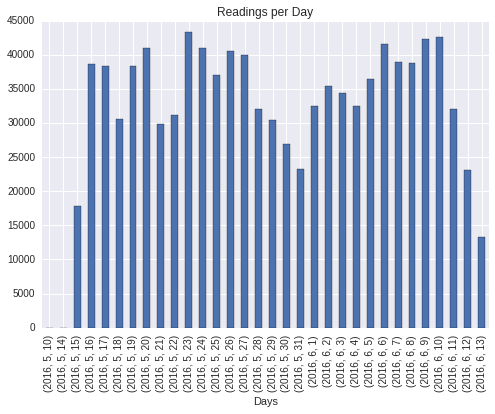

In [126]:
timestamps = readings_dataset['Timestamp']
ax = timestamps.groupby([timestamps.dt.year, timestamps.dt.month, timestamps.dt.day]).count().plot(kind="bar")
ax.set_xlabel('Days')
ax.set_title('Readings per Day')

#### Observations:
* We have very few readings before the 16/5/2016 and after 12/6/2016
* The number of readings in each day varies widely

#### Discard Out of Range Data
We will only keep data between 16/05/2016 and 12/6/2016, which is 4 weeks of data.

In [127]:
start_date = date(2016, 5, 16)
end_date = date(2016, 6, 13)
days = set(pd.date_range(start=start_date, end=end_date, closed='left'))
           
readings_dataset = readings_dataset[(timestamps > start_date) & (timestamps < end_date)]

#### Readings Consistency Through Days
Lets get some insight about which stations do not have readings during an entire day

In [128]:
# get a subview of the readings dataset
id_timestamp_view = readings_dataset.loc[:,['Id','Timestamp']]

# remove the time component of the timestamp
id_timestamp_view['Timestamp'] = id_timestamp_view['Timestamp'].apply(lambda x: x.replace(hour=0, minute=0, second=0, microsecond=0))

# compute the days of readings per stations
days_readings = id_timestamp_view.groupby('Id').aggregate(lambda x: set(x))
days_readings['MissingDays'] = days_readings['Timestamp'].apply(lambda x: list(days - x))
days_readings['MissingDaysCount'] = days_readings['MissingDays'].apply(lambda x: len(x))

In [129]:
def expand_datetime(df, datetime_col):
    df['Weekday'] = df[datetime_col].apply(lambda x: x.weekday())
    return df

In [130]:
# get the stations with missing readings only
missing_days_readings = days_readings[days_readings['MissingDaysCount'] != 0]
missing_days_readings = missing_days_readings['MissingDays'].apply(lambda x: pd.Series(x)).unstack().dropna()
missing_days_readings.index = missing_days_readings.index.droplevel()

# sort and format in their own DF
missing_days_readings = pd.DataFrame(missing_days_readings, columns=['MissingDay'], index=None).reset_index().sort_values(by=['Id', 'MissingDay'])

# expand the missing day date
expand_datetime(missing_days_readings, 'MissingDay')

,Id,MissingDay,Weekday
0,BikePoints_112,2016-05-25,2
29,BikePoints_112,2016-05-26,3
30,BikePoints_120,2016-06-10,4
1,BikePoints_120,2016-06-11,5
2,BikePoints_218,2016-06-04,5
3,BikePoints_226,2016-05-16,0
31,BikePoints_31,2016-05-16,0
67,BikePoints_31,2016-05-17,1
97,BikePoints_31,2016-05-18,2
123,BikePoints_31,2016-05-19,3


In [131]:
missing_days_readings['Id'].nunique()

29

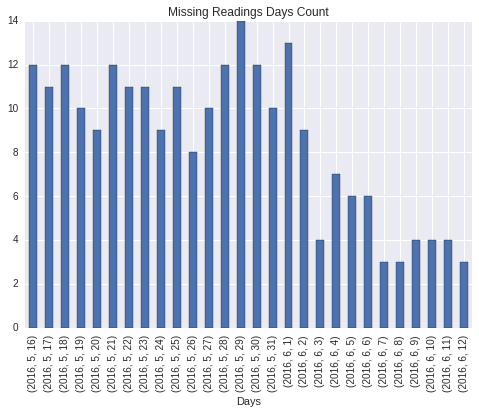

In [132]:
# plot the missing readings days 
days = missing_days_readings['MissingDay']
missing_days_counts = days.groupby([days.dt.year, days.dt.month, days.dt.day]).count()
ax = missing_days_counts.plot(kind="bar")
ax.set_xlabel('Days')
ax.set_title('Missing Readings Days Count')

Stations with no readings in at least one day

In [133]:
missing_days_readings_stations = stations_dataset[stations_dataset['Id'].isin(missing_days_readings['Id'].unique())]
draw_stations_map(missing_days_readings_stations)

Stations with no readings in at least one day during the weekend

In [134]:
weekend_readings = missing_days_readings[missing_days_readings['Weekday'] > 4]
missing_dayreadings_stn = stations_dataset[stations_dataset['Id'].isin(weekend_readings['Id'].unique())]
draw_stations_map(missing_dayreadings_stn)

Stations with no readings in at least one day during weekdays

In [135]:
weekday_readings = missing_days_readings[missing_days_readings['Weekday'] < 5]
missing_dayreadings_stn = stations_dataset[stations_dataset['Id'].isin(weekday_readings['Id'].unique())]
draw_stations_map(missing_dayreadings_stn)

Observations:
* There are 29 stations that do not have readings in at least one day
* There were more stations without readings during May than in June
* Other than that, there is no visible pattern

#### Expand Timestamp

In [136]:
def expand_datetime(df, datetime_col):
    df['Weekday'] = df[datetime_col].apply(lambda x: x.dayofweek) # Monday=0, Sunday=6
    df['Minute'] = df[datetime_col].apply(lambda x: x.minute)
    df['Hour'] = df[datetime_col].apply(lambda x: x.hour)
    return df

expand_datetime(readings_dataset, 'Timestamp')

,Id,Timestamp,NbBikes,NbDocks,NbEmptyDocks,NbUnusableDocks,Weekday,Minute,Hour
91892,BikePoints_482,2016-05-16 00:00:31.437,7,26,19,0,0,0,0
91782,BikePoints_359,2016-05-16 00:00:31.437,3,18,15,0,0,0,0
92513,BikePoints_325,2016-05-16 00:05:36.750,6,18,11,1,0,5,0
92545,BikePoints_360,2016-05-16 00:05:36.750,6,27,20,1,0,5,0
92613,BikePoints_441,2016-05-16 00:05:36.750,11,24,12,1,0,5,0
92666,BikePoints_495,2016-05-16 00:05:36.750,12,38,26,0,0,5,0
92702,BikePoints_534,2016-05-16 00:05:36.750,16,27,9,2,0,5,0
92744,BikePoints_578,2016-05-16 00:05:36.750,25,32,7,0,0,5,0
92751,BikePoints_587,2016-05-16 00:05:36.750,5,22,17,0,0,5,0
92782,BikePoints_618,2016-05-16 00:05:36.750,2,24,22,0,0,5,0


#### Discard Non Relevant Data

In [137]:
readings_dataset = readings_dataset.drop(readings_dataset[(readings_dataset['Hour'] < 7) | (readings_dataset['Hour'] > 22)].index)

#### Save Dataset

In [138]:
pickle.dump(readings_dataset, open("data/parsed/readings_dataset_final.p", "wb"))